<a href="https://colab.research.google.com/github/meghana-0211/Multilingual--Fake-News/blob/main/Multilingual_fake_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
MODEL ARCHITECTURE
IndicBERT + BiLSTM with Attention for Multilingual Fake News Detection

Author: Your Name
Architecture: Ensemble of IndicBERT and BiLSTM with Multi-head Attention
Languages: Hindi, Gujarati, Marathi, Telugu
"""

import torch
import torch.nn as nn
from transformers import AutoModel, AutoConfig

In [2]:
!pip install transformers datasets accelerate -q

In [3]:
import torch
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")



GPU Available: True
GPU Name: Tesla T4
GPU Memory: 14.7 GB


In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AutoConfig, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    import random
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)


In [5]:
class BiLSTMWithAttention(nn.Module):
    """BiLSTM with Multi-head Attention"""

    def __init__(self, input_dim, hidden_dim, num_layers, num_heads, dropout):
        super().__init__()

        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_dim * 2,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )

        self.layer_norm = nn.LayerNorm(hidden_dim * 2)

    def forward(self, x, mask=None):
        lstm_out, _ = self.lstm(x)
        attn_out, attn_weights = self.attention(lstm_out, lstm_out, lstm_out, key_padding_mask=mask)
        attn_out = self.layer_norm(attn_out + lstm_out)

        if mask is not None:
            mask_expanded = (~mask).unsqueeze(-1).float()
            attn_out = attn_out * mask_expanded
            pooled = attn_out.sum(dim=1) / mask_expanded.sum(dim=1)
        else:
            pooled = attn_out.mean(dim=1)

        return pooled, attn_weights



In [6]:
class IndicBERTBiLSTMEnsemble(nn.Module):
    """IndicBERT + BiLSTM Ensemble Model"""

    def __init__(
        self,
        bert_model_name='ai4bharat/indic-bert',
        lstm_hidden_dim=256,
        lstm_num_layers=2,
        attention_heads=8,
        dropout=0.3,
        num_classes=2
    ):
        super().__init__()

        # IndicBERT
        self.bert = AutoModel.from_pretrained(bert_model_name)
        self.bert_config = AutoConfig.from_pretrained(bert_model_name)
        bert_dim = self.bert_config.hidden_size

        # BiLSTM with Attention
        self.bilstm = BiLSTMWithAttention(
            input_dim=bert_dim,
            hidden_dim=lstm_hidden_dim,
            num_layers=lstm_num_layers,
            num_heads=attention_heads,
            dropout=dropout
        )

        self.dropout = nn.Dropout(dropout)

        # Classifiers
        self.bert_classifier = nn.Sequential(
            nn.Linear(bert_dim, bert_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(bert_dim // 2, num_classes)
        )

        lstm_output_dim = lstm_hidden_dim * 2
        self.lstm_classifier = nn.Sequential(
            nn.Linear(lstm_output_dim, lstm_output_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(lstm_output_dim // 2, num_classes)
        )

        # Fusion layer
        self.fusion_layer = nn.Sequential(
            nn.Linear(bert_dim + lstm_output_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        # BERT path
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        bert_pooled = self.dropout(bert_outputs.pooler_output)
        bert_logits = self.bert_classifier(bert_pooled)

        # BiLSTM path
        bert_sequence = bert_outputs.last_hidden_state
        padding_mask = (attention_mask == 0)
        lstm_pooled, attn_weights = self.bilstm(bert_sequence, padding_mask)
        lstm_pooled = self.dropout(lstm_pooled)
        lstm_logits = self.lstm_classifier(lstm_pooled)

        # Ensemble fusion
        combined_features = torch.cat([bert_pooled, lstm_pooled], dim=1)
        final_logits = self.fusion_layer(combined_features)

        return {
            'logits': final_logits,
            'bert_logits': bert_logits,
            'lstm_logits': lstm_logits,
            'attention_weights': attn_weights
        }



In [7]:
class FakeNewsDataset(Dataset):
    """Dataset for multilingual fake news"""

    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }



In [8]:
def train_epoch(model, dataloader, optimizer, scheduler, device, criterion):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    progress_bar = tqdm(dataloader, desc='Training')

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs['logits'], labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        preds = torch.argmax(outputs['logits'], dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Update progress bar
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)

    return avg_loss, accuracy



In [9]:
def evaluate(model, dataloader, device, criterion):
    """Evaluate model"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs['logits'], labels)

            total_loss += loss.item()

            preds = torch.argmax(outputs['logits'], dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')

    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': all_preds,
        'labels': all_labels
    }


In [11]:
pip install huggingface_hub -q

In [12]:
from huggingface_hub import notebook_login

notebook_login()

In [13]:
print("Loading data...")

# Load datasets
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')
test_df = pd.read_csv('test.csv')

print(f"Train: {len(train_df):,} articles")
print(f"Val:   {len(val_df):,} articles")
print(f"Test:  {len(test_df):,} articles")

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained('ai4bharat/indic-bert')

# Create datasets
train_dataset = FakeNewsDataset(train_df['text'].values, train_df['label'].values, tokenizer)
val_dataset = FakeNewsDataset(val_df['text'].values, val_df['label'].values, tokenizer)
test_dataset = FakeNewsDataset(test_df['text'].values, test_df['label'].values, tokenizer)

# Create dataloaders
BATCH_SIZE = 16  # Adjust based on GPU memory

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(f"\nBatch size: {BATCH_SIZE}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")



Loading data...
Train: 53,860 articles
Val:   11,542 articles
Test:  11,542 articles


config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]


Batch size: 16
Train batches: 3367
Val batches: 722


After successfully logging in, you can rerun the cell that caused the error (cell `4MJVLNOMVNSG`) to load the tokenizer and data.

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create model
model = IndicBERTBiLSTMEnsemble()
model = model.to(device)

# Count parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTrainable parameters: {trainable_params:,}")

# Training configuration
NUM_EPOCHS = 3  # Can increase to 5 for better results
LEARNING_RATE = 2e-5

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

# Scheduler
num_training_steps = len(train_loader) * NUM_EPOCHS
num_warmup_steps = num_training_steps // 10

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

# Loss function
criterion = nn.CrossEntropyLoss()

print(f"\nTraining configuration:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Warmup steps: {num_warmup_steps}")
print(f"  Total steps: {num_training_steps}")


Using device: cuda


pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/25 [00:00<?, ?it/s]

AlbertModel LOAD REPORT from: ai4bharat/indic-bert
Key                              | Status     |  | 
---------------------------------+------------+--+-
predictions.dense.weight         | UNEXPECTED |  | 
sop_classifier.classifier.weight | UNEXPECTED |  | 
predictions.LayerNorm.weight     | UNEXPECTED |  | 
predictions.decoder.weight       | UNEXPECTED |  | 
predictions.dense.bias           | UNEXPECTED |  | 
predictions.decoder.bias         | UNEXPECTED |  | 
sop_classifier.classifier.bias   | UNEXPECTED |  | 
predictions.bias                 | UNEXPECTED |  | 
predictions.LayerNorm.bias       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


model.safetensors:   0%|          | 0.00/135M [00:00<?, ?B/s]


Trainable parameters: 38,765,574

Training configuration:
  Epochs: 3
  Learning rate: 2e-05
  Warmup steps: 1010
  Total steps: 10101


In [16]:
print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60)

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_f1': []
}

best_val_f1 = 0
best_model_state = None

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
    print("-" * 60)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, device, criterion)

    # Validate
    val_metrics = evaluate(model, val_loader, device, criterion)

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_metrics['loss'])
    history['val_acc'].append(val_metrics['accuracy'])
    history['val_f1'].append(val_metrics['f1'])

    # Print metrics
    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_metrics['loss']:.4f} | Val Acc:   {val_metrics['accuracy']:.4f}")
    print(f"Val F1:     {val_metrics['f1']:.4f} | Val Precision: {val_metrics['precision']:.4f} | Val Recall: {val_metrics['recall']:.4f}")

    # Save best model
    if val_metrics['f1'] > best_val_f1:
        best_val_f1 = val_metrics['f1']
        best_model_state = model.state_dict().copy()
        print(f"✓ New best model! F1: {best_val_f1:.4f}")

elapsed = time.time() - start_time
print(f"\nTraining completed in {elapsed/60:.1f} minutes")
print(f"Best validation F1: {best_val_f1:.4f}")




STARTING TRAINING

Epoch 1/3
------------------------------------------------------------


Training:   0%|          | 0/3367 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/722 [00:00<?, ?it/s]


Train Loss: 0.1865 | Train Acc: 0.9300
Val Loss:   0.0479 | Val Acc:   0.9910
Val F1:     0.9908 | Val Precision: 0.9979 | Val Recall: 0.9838
✓ New best model! F1: 0.9908

Epoch 2/3
------------------------------------------------------------


Training:   0%|          | 0/3367 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/722 [00:00<?, ?it/s]


Train Loss: 0.0286 | Train Acc: 0.9948
Val Loss:   0.0361 | Val Acc:   0.9935
Val F1:     0.9934 | Val Precision: 0.9909 | Val Recall: 0.9959
✓ New best model! F1: 0.9934

Epoch 3/3
------------------------------------------------------------


Training:   0%|          | 0/3367 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/722 [00:00<?, ?it/s]


Train Loss: 0.0097 | Train Acc: 0.9981
Val Loss:   0.0258 | Val Acc:   0.9959
Val F1:     0.9959 | Val Precision: 0.9961 | Val Recall: 0.9956
✓ New best model! F1: 0.9959

Training completed in 141.1 minutes
Best validation F1: 0.9959


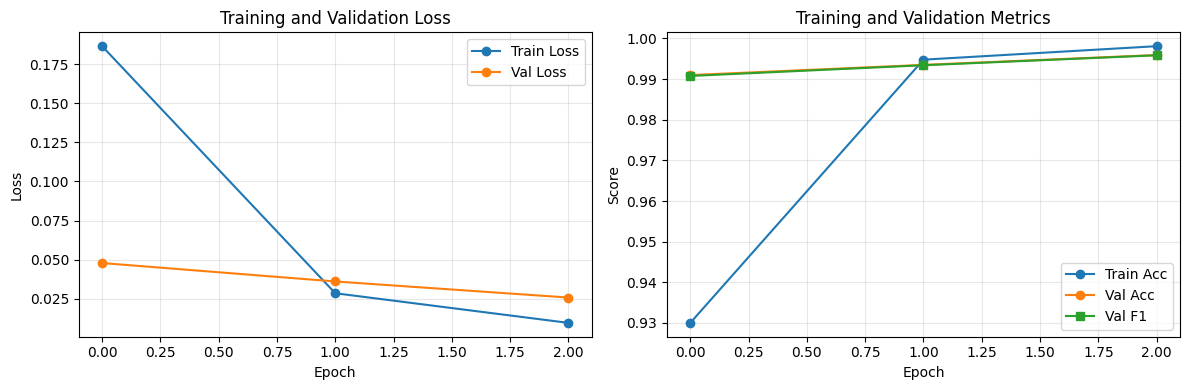

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='o')
axes[1].plot(history['val_f1'], label='Val F1', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('Training and Validation Metrics')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()




FINAL EVALUATION ON TEST SET


Evaluating:   0%|          | 0/722 [00:00<?, ?it/s]


Test Results:
  Accuracy:  0.9971
  Precision: 0.9968
  Recall:    0.9972
  F1-Score:  0.9970

Detailed Classification Report:
              precision    recall  f1-score   support

        Real       1.00      1.00      1.00      5865
        Fake       1.00      1.00      1.00      5677

    accuracy                           1.00     11542
   macro avg       1.00      1.00      1.00     11542
weighted avg       1.00      1.00      1.00     11542



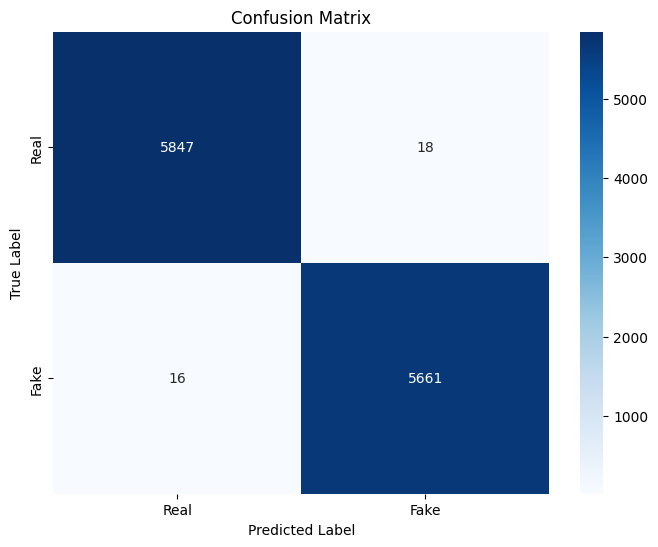

In [18]:
print("\n" + "="*60)
print("FINAL EVALUATION ON TEST SET")
print("="*60)

# Load best model
model.load_state_dict(best_model_state)

# Evaluate on test set
test_metrics = evaluate(model, test_loader, device, criterion)

print(f"\nTest Results:")
print(f"  Accuracy:  {test_metrics['accuracy']:.4f}")
print(f"  Precision: {test_metrics['precision']:.4f}")
print(f"  Recall:    {test_metrics['recall']:.4f}")
print(f"  F1-Score:  {test_metrics['f1']:.4f}")

# Classification report
print("\nDetailed Classification Report:")
print(classification_report(
    test_metrics['labels'],
    test_metrics['predictions'],
    target_names=['Real', 'Fake']
))

# Confusion matrix
cm = confusion_matrix(test_metrics['labels'], test_metrics['predictions'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'],
            yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()



In [20]:
import os

In [22]:
checkpoint = {
    'model_state_dict': best_model_state,
    'test_accuracy': test_metrics['accuracy'],
    'test_f1': test_metrics['f1'],
    'epoch': NUM_EPOCHS,
    'history': history
}

torch.save(checkpoint, 'best_model.pth')
print("\n✓ Model saved as 'best_model.pth'")
print(f"  File size: {os.path.getsize('best_model.pth') / 1024 / 1024:.1f} MB")

# Download model
print("\nDownloading model...")

print("\n" + "="*60)
print("✓ TRAINING COMPLETE!")
print("="*60)
print(f"Final test accuracy: {test_metrics['accuracy']:.4f}")
print(f"Final test F1-score: {test_metrics['f1']:.4f}")









✓ Model saved as 'best_model.pth'
  File size: 147.9 MB


✓ TRAINING COMPLETE!
Final test accuracy: 0.9971
Final test F1-score: 0.9970
